# 생성 모델을 위한 딥러닝

In [1]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
tf.config.set_visible_devices([], 'GPU')

## 1. LSTM으로 텍스트 생성하기

### 1.1. 샘플링 전략의 중요성

In [2]:
# 다른 온도 값을 사용하여 확률 분포의 가중치 바꾸기
import numpy as np


def reweight_distribution(original_distribution, temperature=0.5):
    distribution = np.log(original_distribution) / temperature
    distribution = np.exp(distribution)
    return distribution / np.sum(distribution)

### 1.2. 글자 수준의 LSTM 텍스트 생성 모델 구현

#### 1.2.1. 데이터 전처리

In [3]:
# 원본 텍스트 파일을 내려받아 파싱하기
import keras
import numpy as np

path = keras.utils.get_file(
    'nietzsche.txt',
    origin='https://s3.amazonaws.com/text-datasets/nietzsche.txt')
text = open(path).read().lower()
print('말뭉치 크기:', len(text))

말뭉치 크기: 600893


In [4]:
# 글자 시퀀스 벡터화하기
maxlen = 60
step = 3

sentences = []

next_chars = []

for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('시퀀스 개수:', len(sentences))

chars = sorted(list(set(text)))
print('고유한 글자:', len(chars))

char_indices = dict((char, chars.index(char)) for char in chars)

print('벡터화...')

x = np.zeros((len(sentences), maxlen, len(chars)), dtype=bool)
y = np.zeros((len(sentences), len(chars)), dtype=bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

시퀀스 개수: 200278
고유한 글자: 57
벡터화...


#### 1.2.2. 네트워크 구성

In [5]:
# 다음 글자를 예측하기 위한 단일 LSTM 모델
from keras import layers

model = keras.models.Sequential()
model.add(layers.LSTM(128, input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))

In [6]:
# 모델 컴파일 설정하기
optimizer = keras.optimizers.RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

#### 1.2.3. 언어 모델 훈련과 샘플링

In [7]:
# 모델의 예측이 주어졌을 때 새로운 글자를 샘플링하는 함수
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)/temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [8]:
# 텍스트 생성 루프
import random
import sys

random.seed(42)
start_index = random.randint(0, len(text) - maxlen - 1)

for epoch in range(1, 60):
    print('에포크', epoch)
    model.fit(x, y, batch_size=128, epochs=1)

    seed_text = text[start_index: start_index + maxlen]

    for temperature in [0.2, 0.5, 1.0, 1.2]:
        print('------ 온도:', temperature)
        generated_text = seed_text
        sys.stdout.write(generated_text)

        for i in range(400):
            sampled = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(generated_text):
                sampled[0, t, char_indices[char]] = 1.

            preds = model.predict(sampled, verbose=0)[0]
            next_index = sample(preds, temperature)
            next_char = chars[next_index]

            generated_text += next_char
            generated_text = generated_text[1:]

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

에포크 1
Train on 200278 samples


2023-06-10 22:22:11.140393: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-06-10 22:22:11.154208: W tensorflow/c/c_api.cc:300] Operation '{name:'training/RMSprop/dense/bias/rms/Assign' id:514 op device:{requested: '', assigned: ''} def:{{{node training/RMSprop/dense/bias/rms/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/RMSprop/dense/bias/rms, training/RMSprop/dense/bias/rms/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


200278/200278 [==============================] - 98s 487us/sample - loss: 1.9661
------ 온도: 0.2
the slowly ascending ranks and classes, in which,
through formed the self--the sour the man the self--the self--the course of 

/opt/homebrew/Caskroom/miniforge/base/envs/keras/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-06-10 22:23:48.629732: W tensorflow/c/c_api.cc:300] Operation '{name:'dense/Softmax' id:281 op device:{requested: '', assigned: ''} def:{{{node dense/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


the suffer the self-instinct of the seess the course the sense of the self--the self--the seess the seem to the soul, and the seess the seess of the seess and the speries to be the self-the in the self-in the most the seess the and it is the present and the self-instince of the the conscience it is the seess the sees to the soul, th
------ 온도: 0.5
the slowly ascending ranks and classes, in which,
through for the not how have regarding and the
present the well, to chearte of the cording to be one see the protime and consequlity forment and it we has experience in the heart in lot
conscience of his or the erilous the present of the see to the explise and in the arts it is the say one a one a seess to be part of the harm, one experience and the will present the be a streng prose, the self-instilition o
------ 온도: 1.0
the slowly ascending ranks and classes, in which,
through formed,
wethes they perhapane. but the spirit
"non ecc5ives the ser"foreood, t maniant it stande the
phesemounes--as

/var/folders/wq/fkgy_5nd6mj8k970rhmj291c0000gn/T/ipykernel_45594/3987834611.py:4: RuntimeWarning: divide by zero encountered in log
  preds = np.log(preds)/temperature


make sthyse,
it an inverte little punished
an had to th
에포크 20
Train on 200278 samples
200278/200278 [==============================] - 101s 506us/sample - loss: 1.3197
------ 온도: 0.2
the slowly ascending ranks and classes, in which,
through for the commanders and the sentiments of the world is the stronger and the strength and the strength and the strength and sense of the same this problems and in the morality and the other and the condition of the problem of the problem and accompation and the morality of the world is the morality of the great the morality of the problem of the most agreeable of the most present the problem of the wo
------ 온도: 0.5
the slowly ascending ranks and classes, in which,
through for the religions and in every conscience the german men who is even is to the possible, one may standament, it is not have as the desire of the great a here, and stronger that the personal contrary the powerful a continue the strunger and speciarm,
and some opinion work of a man a

## 2. 딥드림

### 2.1. 케라스 딥드림 구현

In [9]:
# 사전 훈련된 인셉션 V3 모델 로드하기
from keras.applications import inception_v3
from keras import backend as K

# 모델을 훈련하지 않음; 모든 훈련 연산을 비활성화
K.set_learning_phase(0)

model = inception_v3.InceptionV3(weights='imagenet', include_top=False)

/opt/homebrew/Caskroom/miniforge/base/envs/keras/lib/python3.10/site-packages/keras/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(
2023-06-11 00:05:59.669967: W tensorflow/c/c_api.cc:300] Operation '{name:'conv2d_80/kernel/Assign' id:3637 op device:{requested: '', assigned: ''} def:{{{node conv2d_80/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](conv2d_80/kernel, conv2d_80/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [10]:
# 딥드림 설정하기
layer_contributions = {
    'mixed2': 0.2,
    'mixed3': 3.,
    'mixed4': 2.,
    'mixed5': 1.5,
}

In [11]:
# 최대화할 손실 정의하기
layer_dict = dict([(layer.name, layer) for layer in model.layers])
loss = K.variable(0.)
for layer_name in layer_contributions:
    coeff = layer_contributions[layer_name]
    activation = layer_dict[layer_name].output

    scaling = K.prod(K.cast(K.shape(activation), 'float32'))
    loss = loss + coeff * K.sum(K.square(activation[:, 2: -2, 2: -2, :])) / scaling

In [12]:
# 경사 상승법 과정
dream = model.input

grads = K.gradients(loss, dream)[0]

grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)

outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)


def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grads_valuds = outs[1]
    return loss_value, grads_valuds


def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('...', i, '번째 손실 :', loss_value)
        x += step * grad_values
    return x

In [13]:
# 유틸리티 함수
import scipy
from keras.preprocessing.image import image_utils as image


def resize_img(img, size):
    img = np.copy(img)
    factors = (1,
               float(size[0]) / img.shape[1],
               float(size[1]) / img.shape[2],
               1)
    return scipy.ndimage.zoom(img, factors, order=1)


def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    image.save_img(fname, pil_img)


def preprocess_image(image_path):
    img = image.load_img(image_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    iimg = inception_v3.preprocess_input(img)
    return img


def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [14]:
# 연속적인 스케일에 걸쳐 경사 상승법 실행하기
import numpy as np

step = 0.01
num_octave = 3
octave_scale = 1.4
iterations = 20

max_loss = 10.

base_image_path = './datasets/original_photo_deep_dream.jpg'

img = preprocess_image(base_image_path)

original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i))
                   for dim in original_shape])
    successive_shapes.append(shape)

successive_shapes = successive_shapes[::-1]

original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    print('처리할 이미지 크기', shape)
    img = resize_img(img, shape)
    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)
    save_img(img, fname='dream_at_scale_' + str(shape) + '.png')

save_img(img, fname='./datasets/final_dream.png')

처리할 이미지 크기 (178, 178)


2023-06-11 00:06:00.893807: W tensorflow/c/c_api.cc:300] Operation '{name:'Variable/Assign' id:5663 op device:{requested: '', assigned: ''} def:{{{node Variable/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](Variable, Variable/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


... 0 번째 손실 : 0.6596664
... 1 번째 손실 : 1.0178872
... 2 번째 손실 : 1.4631894
... 3 번째 손실 : 1.9751308
... 4 번째 손실 : 2.5786664
... 5 번째 손실 : 3.0955455
... 6 번째 손실 : 3.5216918
... 7 번째 손실 : 4.042058
... 8 번째 손실 : 4.4583883
... 9 번째 손실 : 4.9161377
... 10 번째 손실 : 5.371697
... 11 번째 손실 : 5.7874227
... 12 번째 손실 : 6.189145
... 13 번째 손실 : 6.555528
... 14 번째 손실 : 6.903559
... 15 번째 손실 : 7.300632
... 16 번째 손실 : 7.7031107
... 17 번째 손실 : 8.056311
... 18 번째 손실 : 8.395983
... 19 번째 손실 : 8.806715
처리할 이미지 크기 (250, 250)
... 0 번째 손실 : 2.2521868
... 1 번째 손실 : 3.6578465
... 2 번째 손실 : 4.8310733
... 3 번째 손실 : 5.7743626
... 4 번째 손실 : 6.6463375
... 5 번째 손실 : 7.5017962
... 6 번째 손실 : 8.23179
... 7 번째 손실 : 8.89871
... 8 번째 손실 : 9.609394
처리할 이미지 크기 (350, 350)
... 0 번째 손실 : 2.3356419
... 1 번째 손실 : 3.5055385
... 2 번째 손실 : 4.6092296
... 3 번째 손실 : 5.642889
... 4 번째 손실 : 6.7537837
... 5 번째 손실 : 8.059149
... 6 번째 손실 : 9.880109


## 3. 뉴럴 스타일 트랜스퍼

In [15]:
# 변수 초깃값 정의하기
from keras.preprocessing.image import image_utils as image

target_image_path = './datasets/portrait.png'
style_reference_image_path = './datasets/popova.jpg'

width, height = image.load_img(target_image_path).size
img_height = 400
img_width = int(width * img_height / height)

In [16]:
# 유틸리티 함수
import numpy as np
from keras.applications import vgg19


def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(img_height, img_width))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img


def deprocess_image(x):
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [17]:
# 사전 훈련된 VGG19 네트워크를 로딩하고 3개 이미지에 적용하기
from keras import backend as K

target_image = K.constant(preprocess_image(target_image_path))
style_reference_image = K.constant(preprocess_image(style_reference_image_path))
combination_image = K.placeholder((1, img_height, img_width, 3))

input_tensor = K.concatenate([target_image,
                              style_reference_image,
                              combination_image], axis=0)

model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet',
                    include_top=False)
print('모델 로드 완료.')

2023-06-11 00:06:04.639657: W tensorflow/c/c_api.cc:300] Operation '{name:'block3_conv2/bias/Assign' id:6558 op device:{requested: '', assigned: ''} def:{{{node block3_conv2/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](block3_conv2/bias, block3_conv2/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


모델 로드 완료.


In [18]:
# 콘텐츠 손실
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

In [19]:
# 스타일 손실
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height * img_width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))


def total_variation_loss(x):
    a = K.square(x[:, :img_height - 1, :img_width - 1, :] - x[:, 1:, :img_width - 1, :])
    b = K.square(x[:, :img_height - 1, :img_width - 1, :] - x[:, :img_height - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

In [20]:
# 최소화할 최종 손실 정하기
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

content_layer = 'block5_conv2'
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

total_variation_weight = 1e-4
style_weight = 1.
content_weight = 0.025

loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = loss + content_weight * content_loss(target_image_features, combination_features)

for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss = loss + (style_weight / len(style_layers)) * sl

loss = loss + total_variation_weight * total_variation_loss(combination_image)

In [21]:
# 경사 하강법 단계 설정하기
grads = K.gradients(loss, combination_image)[0]

fetch_loss_and_grads = K.function([combination_image], [loss, grads])


class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grad_values = None

    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_height, img_width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values


evaluator = Evaluator()

In [22]:
# 스타일 트랜스퍼 반복 루프
from scipy.optimize import fmin_l_bfgs_b
import time

result_prefix = 'style_transfer_result'
iterations = 20

x = preprocess_image(target_image_path)
x = x.flatten()

for i in range(iterations):
    print('반복 횟수:', i)

    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss,
                                     x,
                                     fprime=evaluator.grads,
                                     maxfun=20)
    print('현재 손실 값:', min_val)

    img = x.copy().reshape((img_height, img_width, 3))
    img = deprocess_image(img)
    fname = result_prefix + '_at_iteration_%d.png' % i
    image.save_img(fname, img)
    print('저장 이미지:', fname)

    end_time = time.time()
    print('%d 번째 반복 완료: %ds' % (i, end_time - start_time))

반복 횟수: 0


2023-06-11 00:06:05.952908: W tensorflow/c/c_api.cc:300] Operation '{name:'Variable_1/Assign' id:6940 op device:{requested: '', assigned: ''} def:{{{node Variable_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](Variable_1, Variable_1/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


현재 손실 값: 8227089400.0
저장 이미지: style_transfer_result_at_iteration_0.png
0 번째 반복 완료: 38s
반복 횟수: 1
현재 손실 값: 3203648500.0
저장 이미지: style_transfer_result_at_iteration_1.png
1 번째 반복 완료: 38s
반복 횟수: 2
현재 손실 값: 2042398000.0
저장 이미지: style_transfer_result_at_iteration_2.png
2 번째 반복 완료: 37s
반복 횟수: 3
현재 손실 값: 1607081600.0
저장 이미지: style_transfer_result_at_iteration_3.png
3 번째 반복 완료: 37s
반복 횟수: 4
현재 손실 값: 1285501200.0
저장 이미지: style_transfer_result_at_iteration_4.png
4 번째 반복 완료: 37s
반복 횟수: 5
현재 손실 값: 1125049500.0
저장 이미지: style_transfer_result_at_iteration_5.png
5 번째 반복 완료: 37s
반복 횟수: 6
현재 손실 값: 1004651000.0
저장 이미지: style_transfer_result_at_iteration_6.png
6 번째 반복 완료: 37s
반복 횟수: 7
현재 손실 값: 912913000.0
저장 이미지: style_transfer_result_at_iteration_7.png
7 번째 반복 완료: 37s
반복 횟수: 8
현재 손실 값: 848413630.0
저장 이미지: style_transfer_result_at_iteration_8.png
8 번째 반복 완료: 37s
반복 횟수: 9
현재 손실 값: 797155500.0
저장 이미지: style_transfer_result_at_iteration_9.png
9 번째 반복 완료: 37s
반복 횟수: 10
현재 손실 값: 740685300.0
저장 이미지: style_transfe

## 4. 변이형 오토인코더를 사용한 이미지 생성

In [23]:
# VAE 인코더 네트워크
import keras
from keras import layers
from keras import backend as K
from keras.models import Model
import numpy as np

img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2

input_img = keras.Input(shape=img_shape)

x = layers.Conv2D(32, 3,
                  padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu',
                  strides=(2, 2))(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

In [24]:
# 잠재 공간 샘플링 함수
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


z = layers.Lambda(sampling)([z_mean, z_log_var])

In [25]:
# 잠재 공간 포인트를 이미지로 매핑하는 VAE 디코더 네트워크
decoder_input = layers.Input(K.int_shape(z)[1:])

x = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)
x = layers.Reshape(shape_before_flattening[1:])(x)
x = layers.Conv2DTranspose(32, 3,
                           padding='same', activation='relu',
                           strides=(2, 2))(x)
x = layers.Conv2D(1, 3,
                  padding='same', activation='sigmoid')(x)

decoder = Model(decoder_input, x)

z_decoded = decoder(z)

In [26]:
# VAE 손실을 계산하기 위해 직접 만든 층
class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x


y = CustomVariationalLayer()([input_img, z_decoded])

In [27]:
# VAE 훈련하기
from keras.datasets import mnist

vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

vae.fit(x=x_train, y=None,
        shuffle=True,
        epochs=10,
        batch_size=batch_size,
        validation_data=(x_test, None))

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_94 (Conv2D)             (None, 28, 28, 32)   320         ['input_3[0][0]']                
                                                                                                  
 conv2d_95 (Conv2D)             (None, 14, 14, 64)   18496       ['conv2d_94[0][0]']              
                                                                                                  
 conv2d_96 (Conv2D)             (None, 14, 14, 64)   36928       ['conv2d_95[0][0]']              
                                                                                            

2023-06-11 00:18:42.821300: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_3/kernel/Assign' id:7821 op device:{requested: '', assigned: ''} def:{{{node dense_3/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_3/kernel, dense_3/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


59968/60000 [============================>.] - ETA: 0s - loss: 109473.5631

/opt/homebrew/Caskroom/miniforge/base/envs/keras/lib/python3.10/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-06-11 00:19:55.605725: W tensorflow/c/c_api.cc:300] Operation '{name:'custom_variational_layer/Mean_2' id:8023 op device:{requested: '', assigned: ''} def:{{{node custom_variational_layer/Mean_2}} = Mean[T=DT_FLOAT, Tidx=DT_INT32, _has_manual_control_dependencies=true, keep_dims=false](custom_variational_layer/add_4, custom_variational_layer/Const_2)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


60000/60000 [==============================] - 77s 1ms/sample - loss: 109415.1773 - val_loss: 0.1978
Epoch 2/10
60000/60000 [==============================] - 73s 1ms/sample - loss: 0.1948 - val_loss: 0.1944
Epoch 3/10
60000/60000 [==============================] - 76s 1ms/sample - loss: 0.1906 - val_loss: 0.1896
Epoch 4/10
60000/60000 [==============================] - 75s 1ms/sample - loss: 0.1883 - val_loss: 0.1877
Epoch 5/10
60000/60000 [==============================] - 74s 1ms/sample - loss: 0.1869 - val_loss: 0.1869
Epoch 6/10
60000/60000 [==============================] - 73s 1ms/sample - loss: 0.1858 - val_loss: 0.1854
Epoch 7/10
60000/60000 [==============================] - 74s 1ms/sample - loss: 0.1850 - val_loss: 0.1843
Epoch 8/10
60000/60000 [==============================] - 75s 1ms/sample - loss: 0.1843 - val_loss: 0.1850
Epoch 9/10
60000/60000 [==============================] - 77s 1ms/sample - loss: 0.1837 - val_loss: 0.1847
Epoch 10/10
60000/60000 [==================

/opt/homebrew/Caskroom/miniforge/base/envs/keras/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-06-11 00:31:13.527946: W tensorflow/c/c_api.cc:300] Operation '{name:'conv2d_98/Sigmoid' id:7946 op device:{requested: '', assigned: ''} def:{{{node conv2d_98/Sigmoid}} = Sigmoid[T=DT_FLOAT, _has_manual_control_dependencies=true](conv2d_98/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


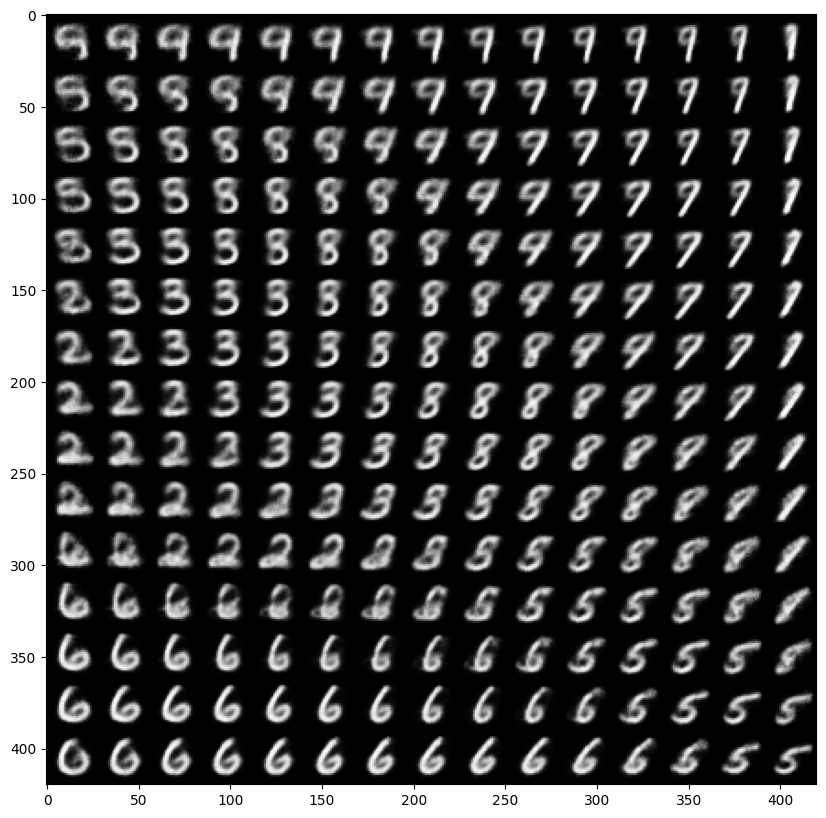

In [28]:
# 2D 잠재 공간에서 포인트 그리드를 샘플링하여 이미지로 디코딩하기
import matplotlib.pyplot as plt
from scipy.stats import norm

n = 15
digit_size = 28
figure = np.zeros((digit_size*n, digit_size * n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)

        digit = x_decoded[1].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

## 5. 적대적 생성 신경망 소개

### 5.1. 생성자

In [29]:
# GAN 생성자 네트워크
import keras
from keras import layers
import numpy as np

latent_dim = 32
height = 32
width = 32
channels = 3

generator_input = keras.Input(shape=(latent_dim,))

x = layers.Dense(128 * 16 * 16)(generator_input)
x = layers.LeakyReLU()(x)
x = layers.Reshape((16, 16, 128))(x)

x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)
generator = keras.models.Model(generator_input, x)
generator.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense_5 (Dense)             (None, 32768)             1081344   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32768)             0         
                                                                 
 reshape_1 (Reshape)         (None, 16, 16, 128)       0         
                                                                 
 conv2d_99 (Conv2D)          (None, 16, 16, 256)       819456    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 256)      1048

### 5.2. 판별자

In [30]:
# GAN 판별자 네트워크
discriminator_input = layers.Input(shape=(height, width, channels))

x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)

x = layers.Flatten()(x)
x = layers.Dropout(0.4)(x)

x = layers.Dense(1, activation='sigmoid')(x)

discriminator = keras.models.Model(discriminator_input, x)
discriminator.summary()

discriminator_optimizer = keras.optimizers.RMSprop(learning_rate=0.0008,
                                                   clipvalue=1.0,
                                                   decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer,
                      loss='binary_crossentropy')

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_103 (Conv2D)         (None, 30, 30, 128)       3584      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 30, 30, 128)       0         
                                                                 
 conv2d_104 (Conv2D)         (None, 14, 14, 128)       262272    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 conv2d_105 (Conv2D)         (None, 6, 6, 128)         262272    
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 6, 6, 128)         0   

### 5.3. 적대적 네트워크

In [31]:
# 적대적 네트워크
discriminator.trainable = False

gan_input = keras.Input(shape=(latent_dim))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)

gan_optimizer = keras.optimizers.RMSprop(learning_rate=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

### 5.4. DCGAN 훈련 방법

In [32]:
# GAN 훈련 구현하기
import os
from keras.preprocessing import image

(x_train, y_train), (_, _) = keras.datasets.cifar10.load_data()

x_train = x_train[y_train.flatten() == 6]

x_train = x_train.reshape((x_train.shape[0],) + (height, width, channels)).astype('float32') / 255.

iterations = 10000
batch_size = 20
save_dir = './datasets/gan_images/'
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

start = 0
for step in range(iterations):
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    generated_images = generator.predict(random_latent_vectors)

    stop = start + batch_size
    real_images = x_train[start: stop]
    combined_images = np.concatenate([generated_images, real_images])

    labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
    labels += 0.05 * np.random.random(labels.shape)

    d_loss = discriminator.train_on_batch(combined_images, labels)

    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    misleading_targets = np.zeros((batch_size, 1))

    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)

    start += batch_size
    if start > len(x_train) - batch_size:
        start = 0
    if step % 100 == 0:
        gan.save_weights('gan.h5')

        print('판별자 손실:', d_loss)
        print('적대적 손실:', a_loss)

        img = image.image_utils.array_to_img(generated_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'generated_frog' + str(step) + '.png'))

        img = image.image_utils.array_to_img(real_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'real_frog' + str(step) + '.png'))

2023-06-11 00:31:15.143814: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_6/kernel/Assign' id:9112 op device:{requested: '', assigned: ''} def:{{{node dense_6/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_6/kernel, dense_6/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2023-06-11 00:31:15.793173: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_2/mul' id:9151 op device:{requested: '', assigned: ''} def:{{{node loss_2/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_2/mul/x, loss_2/dense_6_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-11 00:31:15.923915: W tensorflow/c/c_api.cc:300] Operation '{name:'training_4/RMSprop/conv2d_105/bias/rms/Assign' id:9466 op device:{requested: '', assigned: ''} def:{{{node training_4/RMSprop/conv2d_105/bias/rms/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_4/RMSprop/conv2d_105/bias/rms, training_4/RMSprop/conv2d_105/bias/rms/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and

판별자 손실: 0.6921977996826172
적대적 손실: 0.6835514307022095
판별자 손실: 0.4917810559272766
적대적 손실: 2.2968246936798096
판별자 손실: 0.646511435508728
적대적 손실: 0.904560923576355
판별자 손실: 0.6797764897346497
적대적 손실: 0.792708694934845
판별자 손실: 0.6943016052246094
적대적 손실: 0.7507885098457336
판별자 손실: 0.712360680103302
적대적 손실: 0.7303063273429871
판별자 손실: 0.6916500926017761
적대적 손실: 0.7508943676948547
판별자 손실: 0.7012820839881897
적대적 손실: 0.7416290044784546
판별자 손실: 0.6869376301765442
적대적 손실: 0.7670332193374634
판별자 손실: 0.6868860125541687
적대적 손실: 0.756808340549469
판별자 손실: 0.6904100179672241
적대적 손실: 0.7769922018051147
판별자 손실: 0.758581280708313
적대적 손실: 0.7398335337638855
판별자 손실: 0.6924344897270203
적대적 손실: 0.7565646171569824
판별자 손실: 0.6723246574401855
적대적 손실: 1.5699342489242554
판별자 손실: 0.7076660990715027
적대적 손실: 0.7813946008682251
판별자 손실: 0.697704017162323
적대적 손실: 0.7501247525215149
판별자 손실: 0.7190629839897156
적대적 손실: 0.7834963798522949
판별자 손실: 0.6905797719955444
적대적 손실: 0.7349453568458557
판별자 손실: 0.6846762895584106
적대적 손실: 